In [1]:
import datetime
import gc
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook

data_dir = Path.home() / 'Desktop/kaggle/data/lanl'
os.environ['DATA_DIR'] = str(data_dir)

In [2]:
import lightgbm as lgb
from tensorflow import keras
from catboost import Pool, CatBoostRegressor
import optuna

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.feature_selection import RFECV, SelectFromModel

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import NuSVR, SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

In [3]:
!ls -lh $DATA_DIR

total 6.0G
-rw-r----- 1 maekawa primarygroup  75K May 31 20:54 CatBoost_2019-05-31_test_2.055_train_1.806.csv
-rw-r----- 1 maekawa primarygroup  76K Jun  1 01:18 CatBoost_2019-06-01_test_1.848_train_1.534.csv
-rw-r----- 1 maekawa primarygroup  75K Jun  1 02:53 CatBoost_2019-06-01_test_1.982_train_1.671.csv
-rw-r----- 1 maekawa primarygroup  75K Jun  1 15:41 CatBoost_2019-06-01_test_2.008_train_1.667.csv
-rw-r----- 1 maekawa primarygroup  75K Jun  1 17:34 CatBoost_2019-06-01_test_2.105_train_1.810.csv
-rw-r----- 1 maekawa primarygroup  75K Jun  1 19:29 CatBoost_2019-06-01_test_2.108_train_1.763.csv
-rw-r----- 1 maekawa primarygroup  75K Jun  1 19:08 CatBoost_2019-06-01_test_2.112_train_1.830.csv
-rw-r----- 1 maekawa primarygroup  75K Jun  1 21:12 CatBoost_2019-06-01_test_2.113_train_1.814.csv
-rw-r----- 1 maekawa primarygroup  75K Jun  1 21:39 CatBoost_2019-06-01_test_2.147_train_1.815.csv
-rw-r----- 1 maekawa primarygroup  75K Jun  1 22:20 CatBoost_2019-06-01_test_2.156_train_1.743.csv

In [4]:
X_train = pd.read_pickle(data_dir / 'df_xtrain_classified_v4.pickle')
y_train = pd.read_pickle(data_dir / 'df_ytrain_stride4_v4.pickle')
X_test = pd.read_pickle(data_dir / 'df_xtest_v4.pickle')

In [5]:
print("Train X: {} y: {} Test X: {}".format(X_train.shape, y_train.shape, X_test.shape))

Train X: (16626, 278) y: (16626, 2) Test X: (2624, 276)


In [6]:
y_train['oof_pred'] = X_train.oof_pred

In [7]:
X_train.sort_values(by='oof_pred', ascending=False, inplace=True)
y_train.sort_values(by='oof_pred', ascending=False, inplace=True)

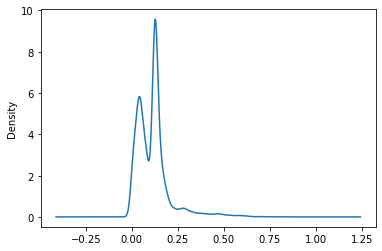

In [8]:
X_train.oof_pred.plot.density()

In [9]:
N = 7000
X_train = X_train.iloc[:N]
y_train = y_train.iloc[:N]

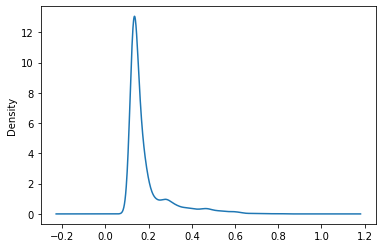

In [10]:
X_train.oof_pred.plot.density()

In [11]:
X_train.sort_index(inplace=True)
y_train.sort_index(inplace=True)

In [12]:
del X_train['oof_pred']
del X_train['target']

In [13]:
print(X_train.shape)
print(X_test.shape)

(7000, 276)
(2624, 276)


In [14]:
discriminators_top250 = [
    'time_from_prev_failure',
    'fftr_max',
    'fftr_abs_max',
] + [
    'ffti_Moving_average_6000_mean',
    'ffti_abs_q01',
    'ffti_av_change_abs_roll_std_10',
    'ffti_av_change_abs_roll_std_100',
    'ffti_av_change_abs_roll_std_1000',
    'ffti_classic_sta_lta3_mean',
    'ffti_mean_change_abs',
    'ffti_min_roll_std_10',
    'ffti_min_roll_std_100',
    'ffti_min_roll_std_1000',
    'ffti_q01_roll_std_100',
    'ffti_q05_roll_std_10',
    'ffti_q05_roll_std_1000',
    'fftr_abs_min',
    'fftr_abs_q01',
    'fftr_max_roll_mean_10',
    'fftr_max_roll_mean_100',
    'fftr_max_to_min_diff',
    'fftr_mean_change_abs',
    'fftr_min_roll_std_10',
    'fftr_min_roll_std_100',
    'fftr_q01_roll_std_10',
    'fftr_q01_roll_std_100',
    'fftr_q05_roll_std_10',
    'fftr_q95_roll_mean_1000',
    'x_abs_trend',
    'x_av_change_abs_roll_mean_10',
    'x_av_change_abs_roll_mean_100',
    'x_av_change_abs_roll_std_10',
    'x_av_change_abs_roll_std_100',
    'x_av_change_abs_roll_std_1000',
    'x_avg_first_10000',
    'x_avg_first_50000',
    'x_avg_last_10000',
    'x_classic_sta_lta2_mean',
    'x_classic_sta_lta4_mean',
    'x_max_first_50000',
    'x_max_roll_mean_1000',
    'x_max_to_min',
    'x_max_to_min_diff',
    'x_min_roll_mean_1000',
    'x_min_roll_std_10',
    'x_min_roll_std_100',
    'x_q01_roll_mean_100',
    'x_q05_roll_mean_100',
    'x_q05_roll_mean_1000',
    'x_q05_roll_std_10',
    'x_q95_roll_mean_1000',
    'x_q99_roll_mean_1000',
    'x_skew',
] + [
    'fftr_abs_max_roll_mean_10',
    'ffti_q01_roll_std_10',
    'fftr_abs_max_roll_mean_100',
    'fftr_min_roll_std_1000',
    'x_q01_roll_mean_1000',
    'ffti_skew',
    'fftr_med',
    'ffti_mean',
    'x_q05_roll_std_100',
    'x_min_roll_mean_100',
    'fftr_av_change_abs_roll_std_10',
    'fftr_q05_roll_mean_1000',
    'fftr_av_change_abs_roll_mean_10',
    'x_avg_last_50000',
    'x_abs_max_roll_mean_1000',
    'ffti_q05_roll_std_100',
    'ffti_avg_first_10000',
    'x_q05_roll_std_1000',
    'ffti_ave10',
    'x_std_roll_mean_1000',
    'x_classic_sta_lta1_mean',
    'ffti_med',
    'fftr_av_change_abs_roll_mean_1000',
    'x_std_first_10000',
    'ffti_q01_roll_std_1000',
    'ffti_trend',
    'x_q95_roll_mean_100',
    'x_min_first_50000',
    'fftr_max_roll_mean_1000',
    'x_min_roll_std_1000',
    'ffti_abs_q05',
    'fftr_q01_roll_std_1000',
    'ffti_kurt',
    'x_av_change_abs_roll_mean_1000',
    'fftr_ave10',
    'x_classic_sta_lta3_mean',
    'fftr_q05_roll_std_100',
    'ffti_Hann_window_mean',
    'fftr_min_roll_mean_1000',
    'fftr_av_change_abs_roll_std_1000',
    'x_q01_roll_std_10',
    'x_q01_roll_std_1000',
    'fftr_avg_first_10000',
    'fftr_q99_roll_mean_1000',
    'x_max_first_10000',
    'ffti_ave_roll_mean_10',
    'x_ave10',
    'ffti_Moving_average_1500_mean',
    'ffti_avg_first_50000',
    'ffti_Moving_average_3000_mean',
] + [
    'x_exp_Moving_average_30000_mean',
    'fftr_av_change_abs_roll_std_100',
    'fftr_abs_trend',
    'ffti_sum',
    'fftr_abs_max_roll_mean_1000',
    'ffti_avg_last_50000',
    'ffti_avg_last_10000',
    'fftr_av_change_abs_roll_mean_100',
    'fftr_avg_last_10000',
    'x_Moving_average_3000_mean',
    'x_min_first_10000',
    'fftr_q95_roll_mean_100',
    'x_exp_Moving_average_3000_mean',
    'fftr_q01_roll_mean_1000',
    'x_q05_roll_mean_10',
    'fftr_max_roll_std_1000',
    'ffti_av_change_abs_roll_mean_10',
    'fftr_Moving_average_6000_mean',
    'fftr_max_roll_std_10',
    'x_q01_roll_std_100',
    'x_q99_roll_mean_100',
    'fftr_q05_roll_std_1000',
    'fftr_avg_last_50000',
    'x_trend',
    'x_min_last_10000',
    'fftr_max_to_min',
    'x_std_first_50000',
    'ffti_ave_roll_mean_100',
    'x_exp_Moving_average_300_mean',
    'ffti_max_roll_std_1000',
    'fftr_trend',
    'fftr_exp_Moving_average_30000_mean',
    'x_max_last_10000',
    'x_max_last_50000',
    'x_std_last_10000',
    'x_iqr',
    'x_Moving_average_6000_mean',
    'ffti_exp_Moving_average_300_mean',
    'ffti_Moving_average_700_mean',
    'ffti_q05_roll_mean_1000',
    'ffti_exp_Moving_average_3000_mean',
    'fftr_abs_q05',
    'x_max',
    'fftr_classic_sta_lta3_mean',
    'ffti_count_big',
    'x_q95_roll_std_1000',
    'fftr_exp_Moving_average_3000_mean',
    'x_Moving_average_1500_mean',
    'x_q95_roll_std_10',
    'x_min_last_50000',
] + [
    'fftr_abs_max_roll_std_10',
    'x_mean',
    'x_Moving_average_700_mean',
    'fftr_std_roll_mean_1000',
    'x_ave_roll_mean_1000',
    'fftr_max_roll_std_100',
    'ffti_av_change_abs_roll_mean_100',
    'ffti_q95_roll_mean_1000',
    'fftr_exp_Moving_average_300_mean',
    'ffti_exp_Moving_average_30000_mean',
    'x_std_last_50000',
    'fftr_q01_roll_mean_100',
    'fftr_avg_first_50000',
    'x_q99_roll_std_1000',
    'x_Hann_window_mean',
    'x_mean_change_abs',
    'x_min_roll_mean_10',
    'fftr_q99_roll_mean_100',
    'x_kurt',
    'fftr_min',
    'ffti_max_roll_std_10',
    'x_max_roll_mean_100',
    'fftr_std_first_10000',
    'ffti_std_roll_mean_1000',
    'ffti_iqr',
    'ffti_ave_roll_mean_1000',
    'x_std_roll_mean_100',
    'fftr_Moving_average_3000_mean',
    'fftr_q05_roll_mean_100',
    'fftr_abs_max_roll_std_1000',
    'fftr_min_roll_mean_100',
    'x_min',
    'fftr_min_roll_mean_10',
    'x_q95_roll_std_100',
    'ffti_av_change_abs_roll_mean_1000',
    'ffti_max_to_min_diff',
    'fftr_max_last_50000',
    'ffti_max_roll_mean_1000',
    'x_max_roll_mean_10',
    'x_max_roll_std_10',
    'ffti_std_roll_mean_100',
    'x_q95_roll_mean_10',
    'ffti_q01_roll_mean_1000',
    'x_max_roll_std_100',
    'fftr_q95_roll_std_100',
    'ffti_min_first_50000',
    'ffti_max_roll_mean_100',
    'ffti_max_roll_mean_10',
    'ffti_q05_roll_mean_100',
    'x_MA_400MA_BB_low_mean'
] + [
    'x_sum',
    'fftr_abs_max_roll_std_100',
    'x_abs_max',
    'x_abs_max_roll_std_10',
    'x_ave_roll_mean_100',
    'x_ave_roll_mean_10',
    'x_abs_max_roll_mean_100',
    'ffti_q99_roll_mean_1000',
    'ffti_abs_max_roll_std_10',
    'fftr_min_first_50000',
    'x_q001',
    'ffti_min_roll_mean_10',
    'fftr_max_last_10000',
    'ffti_min_roll_mean_1000',
    'x_abs_max_roll_mean_10',
    'ffti_min_roll_mean_100',
    'fftr_std_roll_mean_100',
    'ffti_q95',
    'ffti_abs_max_roll_std_1000',
    'fftr_iqr',
    'ffti_q95_roll_mean_100',
    'fftr_Moving_average_700_mean',
    'fftr_count_big',
    'fftr_q95',
    'x_max_roll_std_1000',
    'x_abs_max_roll_std_100',
    'fftr_q999',
    'ffti_abs_max_roll_mean_1000',
    'fftr_ave_roll_mean_1000',
    'ffti_q01_roll_mean_100',
    'fftr_Hann_window_mean',
    'x_MA_700MA_BB_low_mean',
    'x_q01_roll_mean_10',
    'x_Hilbert_mean',
    'fftr_q95_roll_std_10',
    'fftr_ave_roll_mean_10',
    'fftr_Moving_average_1500_mean',
    'ffti_q95_roll_std_100',
    'ffti_max_roll_std_100',
    'fftr_classic_sta_lta4_mean',
    'fftr_q05_roll_mean_10',
    'fftr_q01_roll_mean_10',
    'fftr_q95_roll_mean_10',
    'ffti_abs_max_roll_mean_100',
    'x_q999',
    'x_q99_roll_mean_10',
    'fftr_q95_roll_std_1000',
    'fftr_min_first_10000',
    'ffti_q05_roll_mean_10',
    'ffti_min_last_50000'
]

In [15]:
train_columns = list(X_train.columns)

for f in discriminators_top250:
    if f in train_columns:
        train_columns.remove(f)

len(train_columns)

118

In [16]:
y_train_label = y_train.time_to_failure

In [23]:
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
import gc
from hyperopt import hp, tpe, Trials, STATUS_OK
from hyperopt.fmin import fmin
from hyperopt.pyll.stochastic import sample
#optional but advised
import warnings
warnings.filterwarnings('ignore')

#GLOBAL HYPEROPT PARAMETERS
NUM_EVALS = 1000 #number of hyperopt evaluation rounds
N_FOLDS = 5 #number of cross-validation folds on data in each evaluation round

#LIGHTGBM PARAMETERS
LGBM_MAX_LEAVES = 2**11 #maximum number of leaves per tree for LightGBM
LGBM_MAX_DEPTH = 25 #maximum tree depth for LightGBM
EVAL_METRIC_LGBM_REG = 'mae' #LightGBM regression metric. Note that 'rmse' is more commonly used 
EVAL_METRIC_LGBM_CLASS = 'auc'#LightGBM classification metric

#XGBOOST PARAMETERS
XGB_MAX_LEAVES = 2**12 #maximum number of leaves when using histogram splitting
XGB_MAX_DEPTH = 25 #maximum tree depth for XGBoost
EVAL_METRIC_XGB_REG = 'mae' #XGBoost regression metric
EVAL_METRIC_XGB_CLASS = 'auc' #XGBoost classification metric

#CATBOOST PARAMETERS
CB_MAX_DEPTH = 8 #maximum tree depth in CatBoost
OBJECTIVE_CB_REG = 'MAE' #CatBoost regression metric
OBJECTIVE_CB_CLASS = 'Logloss' #CatBoost classification metric

#OPTIONAL OUTPUT
BEST_SCORE = 0

def quick_hyperopt(data, labels, package='lgbm', num_evals=NUM_EVALS, diagnostic=False):
    
    #==========
    #LightGBM
    #==========
    
    if package=='lgbm':
        
        print('Running {} rounds of LightGBM parameter optimisation:'.format(num_evals))
        #clear space
        gc.collect()
        
        integer_params = ['max_depth',
                         'num_leaves',
                          'max_bin',
                         'min_data_in_leaf',
                         'min_data_in_bin']
        
        def objective(space_params):
            
            #cast integer params from float to int
            for param in integer_params:
                space_params[param] = int(space_params[param])
            
            #extract nested conditional parameters
            if space_params['boosting']['boosting'] == 'goss':
                top_rate = space_params['boosting'].get('top_rate')
                other_rate = space_params['boosting'].get('other_rate')
                #0 <= top_rate + other_rate <= 1
                top_rate = max(top_rate, 0)
                top_rate = min(top_rate, 0.5)
                other_rate = max(other_rate, 0)
                other_rate = min(other_rate, 0.5)
                space_params['top_rate'] = top_rate
                space_params['other_rate'] = other_rate
            
            subsample = space_params['boosting'].get('subsample', 1.0)
            space_params['boosting'] = space_params['boosting']['boosting']
            space_params['subsample'] = subsample
            
            #for classification, set stratified=True and metrics=EVAL_METRIC_LGBM_CLASS
            cv_results = lgb.cv(space_params, train, nfold = N_FOLDS, stratified=False,
                                early_stopping_rounds=100, metrics=EVAL_METRIC_LGBM_REG, seed=42)
            
            best_loss = cv_results['l1-mean'][-1] #'l2-mean' for rmse
            #for classification, comment out the line above and uncomment the line below:
            #best_loss = 1 - cv_results['auc-mean'][-1]
            #if necessary, replace 'auc-mean' with '[your-preferred-metric]-mean'
            return{'loss':best_loss, 'status': STATUS_OK }
        
        train = lgb.Dataset(data, labels)
                
        #integer and string parameters, used with hp.choice()
        boosting_list = [{'boosting': 'gbdt',
                          'subsample': hp.uniform('subsample', 0.5, 1)},
                         {'boosting': 'goss',
                          'subsample': 1.0,
                         'top_rate': hp.uniform('top_rate', 0, 0.5),
                         'other_rate': hp.uniform('other_rate', 0, 0.5)}] #if including 'dart', make sure to set 'n_estimators'
        metric_list = ['MAE', 'RMSE'] 
        #for classification comment out the line above and uncomment the line below
        #metric_list = ['auc'] #modify as required for other classification metrics
        objective_list_reg = ['huber', 'gamma', 'fair', 'tweedie']
        objective_list_class = ['binary', 'cross_entropy']
        #for classification set objective_list = objective_list_class
        objective_list = objective_list_reg

        space ={'boosting' : hp.choice('boosting', boosting_list),
                'num_leaves' : hp.quniform('num_leaves', 2, LGBM_MAX_LEAVES, 1),
                'max_depth': hp.quniform('max_depth', 2, LGBM_MAX_DEPTH, 1),
                'max_bin': hp.quniform('max_bin', 32, 255, 1),
                'min_data_in_leaf': hp.quniform('min_data_in_leaf', 1, 256, 1),
                'min_data_in_bin': hp.quniform('min_data_in_bin', 1, 256, 1),
                'min_gain_to_split' : hp.quniform('min_gain_to_split', 0.1, 5, 0.01),
                'lambda_l1' : hp.uniform('lambda_l1', 0, 5),
                'lambda_l2' : hp.uniform('lambda_l2', 0, 5),
                'learning_rate' : hp.loguniform('learning_rate', np.log(0.005), np.log(0.2)),
                'metric' : hp.choice('metric', metric_list),
                'objective' : hp.choice('objective', objective_list),
                'feature_fraction' : hp.quniform('feature_fraction', 0.5, 1, 0.01),
                'bagging_fraction' : hp.quniform('bagging_fraction', 0.5, 1, 0.01)
            }
        
        #optional: activate GPU for LightGBM
        #follow compilation steps here:
        #https://www.kaggle.com/vinhnguyen/gpu-acceleration-for-lightgbm/
        #then uncomment lines below:
        #space['device'] = 'gpu'
        #space['gpu_platform_id'] = 0,
        #space['gpu_device_id'] =  0

        trials = Trials()
        best = fmin(fn=objective,
                    space=space,
                    algo=tpe.suggest,
                    max_evals=num_evals, 
                    trials=trials)
                
        #fmin() will return the index of values chosen from the lists/arrays in 'space'
        #to obtain actual values, index values are used to subset the original lists/arrays
        best['boosting'] = boosting_list[best['boosting']]['boosting']#nested dict, index twice
        best['metric'] = metric_list[best['metric']]
        best['objective'] = objective_list[best['objective']]
                
        #cast floats of integer params to int
        for param in integer_params:
            best[param] = int(best[param])
        
        print('{' + '\n'.join('{}: {}'.format(k, v) for k, v in best.items()) + '}')
        if diagnostic:
            return(best, trials)
        else:
            return(best)
    
    #==========
    #XGBoost
    #==========
    
    if package=='xgb':
        
        print('Running {} rounds of XGBoost parameter optimisation:'.format(num_evals))
        #clear space
        gc.collect()
        
        integer_params = ['max_depth']
        
        def objective(space_params):
            
            for param in integer_params:
                space_params[param] = int(space_params[param])
                
            #extract multiple nested tree_method conditional parameters
            #libera te tutemet ex inferis
            if space_params['tree_method']['tree_method'] == 'hist':
                max_bin = space_params['tree_method'].get('max_bin')
                space_params['max_bin'] = int(max_bin)
                if space_params['tree_method']['grow_policy']['grow_policy']['grow_policy'] == 'depthwise':
                    grow_policy = space_params['tree_method'].get('grow_policy').get('grow_policy').get('grow_policy')
                    space_params['grow_policy'] = grow_policy
                    space_params['tree_method'] = 'hist'
                else:
                    max_leaves = space_params['tree_method']['grow_policy']['grow_policy'].get('max_leaves')
                    space_params['grow_policy'] = 'lossguide'
                    space_params['max_leaves'] = int(max_leaves)
                    space_params['tree_method'] = 'hist'
            else:
                space_params['tree_method'] = space_params['tree_method'].get('tree_method')
                
            #for classification replace EVAL_METRIC_XGB_REG with EVAL_METRIC_XGB_CLASS
            cv_results = xgb.cv(space_params, train, nfold=N_FOLDS, metrics=[EVAL_METRIC_XGB_REG],
                             early_stopping_rounds=100, stratified=False, seed=42)
            
            best_loss = cv_results['test-mae-mean'].iloc[-1] #or 'test-rmse-mean' if using RMSE
            #for classification, comment out the line above and uncomment the line below:
            #best_loss = 1 - cv_results['test-auc-mean'].iloc[-1]
            #if necessary, replace 'test-auc-mean' with 'test-[your-preferred-metric]-mean'
            return{'loss':best_loss, 'status': STATUS_OK }
        
        train = xgb.DMatrix(data, labels)
        
        #integer and string parameters, used with hp.choice()
        boosting_list = ['gbtree', 'gblinear'] #if including 'dart', make sure to set 'n_estimators'
        metric_list = ['MAE', 'RMSE'] 
        #for classification comment out the line above and uncomment the line below
        #metric_list = ['auc']
        #modify as required for other classification metrics classification
        
        tree_method = [{'tree_method' : 'exact'},
               {'tree_method' : 'approx'},
               {'tree_method' : 'hist',
                'max_bin': hp.quniform('max_bin', 2**3, 2**7, 1),
                'grow_policy' : {'grow_policy': {'grow_policy':'depthwise'},
                                'grow_policy' : {'grow_policy':'lossguide',
                                                  'max_leaves': hp.quniform('max_leaves', 32, XGB_MAX_LEAVES, 1)}}}]
        
        #if using GPU, replace 'exact' with 'gpu_exact' and 'hist' with
        #'gpu_hist' in the nested dictionary above
        
        objective_list_reg = ['reg:squarederror', 'reg:gamma', 'reg:tweedie']
        objective_list_class = ['reg:logistic', 'binary:logistic']
        #for classification change line below to 'objective_list = objective_list_class'
        objective_list = objective_list_reg
        
        space ={'boosting' : hp.choice('boosting', boosting_list),
                'tree_method' : hp.choice('tree_method', tree_method),
                'max_depth': hp.quniform('max_depth', 2, XGB_MAX_DEPTH, 1),
                'reg_alpha' : hp.uniform('reg_alpha', 0, 5),
                'reg_lambda' : hp.uniform('reg_lambda', 0, 5),
                'min_child_weight' : hp.uniform('min_child_weight', 0, 5),
                'gamma' : hp.uniform('gamma', 0, 5),
                'learning_rate' : hp.loguniform('learning_rate', np.log(0.005), np.log(0.2)),
                'eval_metric' : hp.choice('eval_metric', metric_list),
                'objective' : hp.choice('objective', objective_list),
                'colsample_bytree' : hp.quniform('colsample_bytree', 0.1, 1, 0.01),
                'colsample_bynode' : hp.quniform('colsample_bynode', 0.1, 1, 0.01),
                'colsample_bylevel' : hp.quniform('colsample_bylevel', 0.1, 1, 0.01),
                'subsample' : hp.quniform('subsample', 0.5, 1, 0.05),
                'nthread' : -1
            }
        
        trials = Trials()
        best = fmin(fn=objective,
                    space=space,
                    algo=tpe.suggest,
                    max_evals=num_evals, 
                    trials=trials)
        
        best['tree_method'] = tree_method[best['tree_method']]['tree_method']
        best['boosting'] = boosting_list[best['boosting']]
        best['eval_metric'] = metric_list[best['eval_metric']]
        best['objective'] = objective_list[best['objective']]
        
        #cast floats of integer params to int
        for param in integer_params:
            best[param] = int(best[param])
        if 'max_leaves' in best:
            best['max_leaves'] = int(best['max_leaves'])
        if 'max_bin' in best:
            best['max_bin'] = int(best['max_bin'])
        
        print('{' + '\n'.join('{}: {}'.format(k, v) for k, v in best.items()) + '}')
        
        if diagnostic:
            return(best, trials)
        else:
            return(best)
    
    #==========
    #CatBoost
    #==========
    
    if package=='cb':
        
        print('Running {} rounds of CatBoost parameter optimisation:'.format(num_evals))
        
        #clear memory 
        gc.collect()
            
        integer_params = ['depth',
                          #'one_hot_max_size', #for categorical data
                          #'min_data_in_leaf',
                          'max_bin']
        
        def objective(space_params):
                        
            #cast integer params from float to int
            for param in integer_params:
                space_params[param] = int(space_params[param])
                
            #extract nested conditional parameters
            if space_params['bootstrap_type']['bootstrap_type'] == 'Bayesian':
                bagging_temp = space_params['bootstrap_type'].get('bagging_temperature')
                space_params['bagging_temperature'] = bagging_temp
                
#             if space_params['grow_policy']['grow_policy'] == 'LossGuide':
#                 max_leaves = space_params['grow_policy'].get('max_leaves')
#                 space_params['max_leaves'] = int(max_leaves)
                
            space_params['bootstrap_type'] = space_params['bootstrap_type']['bootstrap_type']
#             space_params['grow_policy'] = space_params['grow_policy']['grow_policy']
                           
            #random_strength cannot be < 0
            space_params['random_strength'] = max(space_params['random_strength'], 0)
            #fold_len_multiplier cannot be < 1
            space_params['fold_len_multiplier'] = max(space_params['fold_len_multiplier'], 1)
                       
            #for classification set stratified=True
            cv_results = cb.cv(train, space_params, fold_count=N_FOLDS, 
                             early_stopping_rounds=25, stratified=False, partition_random_seed=42)
           
            best_loss = cv_results['test-MAE-mean'].iloc[-1] #'test-RMSE-mean' for RMSE
            #for classification, comment out the line above and uncomment the line below:
            #best_loss = cv_results['test-Logloss-mean'].iloc[-1]
            #if necessary, replace 'test-Logloss-mean' with 'test-[your-preferred-metric]-mean'
            
            return{'loss':best_loss, 'status': STATUS_OK}
        
        train = cb.Pool(data, labels.astype('float32'))
        
        #integer and string parameters, used with hp.choice()
        bootstrap_type = [  #{'bootstrap_type':'Poisson'}, 
                           {'bootstrap_type':'Bayesian',
                            'bagging_temperature' : hp.loguniform('bagging_temperature', np.log(1), np.log(50))},
                          {'bootstrap_type':'Bernoulli'}] 
        LEB = ['No', 'AnyImprovement'] #remove 'Armijo' if not using GPU
        #score_function = ['Correlation', 'L2', 'NewtonCorrelation', 'NewtonL2']
        grow_policy = [{'grow_policy':'SymmetricTree'},
                       {'grow_policy':'Depthwise'},
                       {'grow_policy':'Lossguide',
                        'max_leaves': hp.quniform('max_leaves', 2, 32, 1)}]
        eval_metric_list_reg = ['MAE', 'RMSE', 'Poisson']
        eval_metric_list_class = ['Logloss', 'AUC', 'F1']
        #for classification change line below to 'eval_metric_list = eval_metric_list_class'
        eval_metric_list = eval_metric_list_reg
                
        space ={'depth': hp.quniform('depth', 2, CB_MAX_DEPTH, 1),
                'max_bin' : hp.quniform('max_bin', 1, 32, 1), #if using CPU just set this to 254
                'l2_leaf_reg' : hp.uniform('l2_leaf_reg', 0, 5),
#                 'min_data_in_leaf' : hp.quniform('min_data_in_leaf', 1, 50, 1),
                'random_strength' : hp.loguniform('random_strength', np.log(0.005), np.log(5)),
                #'one_hot_max_size' : hp.quniform('one_hot_max_size', 2, 16, 1), #uncomment if using categorical features
                'bootstrap_type' : hp.choice('bootstrap_type', bootstrap_type),
                'learning_rate' : hp.uniform('learning_rate', 0.05, 0.25),
                'eval_metric' : hp.choice('eval_metric', eval_metric_list),
                'objective' : OBJECTIVE_CB_REG,
                #'score_function' : hp.choice('score_function', score_function), #crashes kernel - reason unknown
                'leaf_estimation_backtracking' : hp.choice('leaf_estimation_backtracking', LEB),
                #'grow_policy': hp.choice('grow_policy', grow_policy),
                #'colsample_bylevel' : hp.quniform('colsample_bylevel', 0.1, 1, 0.01),# CPU only
                'fold_len_multiplier' : hp.loguniform('fold_len_multiplier', np.log(1.01), np.log(2.5)),
                'od_type' : 'Iter',
                'od_wait' : 25,
                'task_type' : 'GPU',
                'verbose' : 0
            }
        
        #optional: run CatBoost without GPU
        #uncomment line below
        space['task_type'] = 'CPU'
            
        trials = Trials()
        best = fmin(fn=objective,
                    space=space,
                    algo=tpe.suggest,
                    max_evals=num_evals, 
                    trials=trials)
        
        #unpack nested dicts first
        best['bootstrap_type'] = bootstrap_type[best['bootstrap_type']]['bootstrap_type']
        #best['grow_policy'] = grow_policy[best['grow_policy']]['grow_policy']
        best['eval_metric'] = eval_metric_list[best['eval_metric']]
        
        #best['score_function'] = score_function[best['score_function']] 
        #best['leaf_estimation_method'] = LEM[best['leaf_estimation_method']] #CPU only
        best['leaf_estimation_backtracking'] = LEB[best['leaf_estimation_backtracking']]        
        
        #cast floats of integer params to int
        for param in integer_params:
            best[param] = int(best[param])
        if 'max_leaves' in best:
            best['max_leaves'] = int(best['max_leaves'])
        
        print('{' + '\n'.join('{}: {}'.format(k, v) for k, v in best.items()) + '}')
        
        if diagnostic:
            return(best, trials)
        else:
            return(best)
    
    else:
        print('Package not recognised. Please use "lgbm" for LightGBM, "xgb" for XGBoost or "cb" for CatBoost.') 

In [24]:
cb_params = quick_hyperopt(X_train, y_train_label, 'cb', 50)
cb_params

Running 50 rounds of CatBoost parameter optimisation:
100%|██████████| 50/50 [3:01:56<00:00, 103.28s/it, best loss: 2.0504313346532688]   
{bootstrap_type: Bernoulli
depth: 8
eval_metric: RMSE
fold_len_multiplier: 1.4665755301338386
l2_leaf_reg: 3.1884879156314594
leaf_estimation_backtracking: AnyImprovement
learning_rate: 0.15692972872529823
max_bin: 18
random_strength: 0.005213763775616797}


{'bootstrap_type': 'Bernoulli',
 'depth': 8,
 'eval_metric': 'RMSE',
 'fold_len_multiplier': 1.4665755301338386,
 'l2_leaf_reg': 3.1884879156314594,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'learning_rate': 0.15692972872529823,
 'max_bin': 18,
 'random_strength': 0.005213763775616797}

In [23]:
xgb_params = quick_hyperopt(X_train, y_train_label, 'xgb', 50)
xgb_params

Running 50 rounds of XGBoost parameter optimisation:
100%|██████████| 50/50 [03:39<00:00,  2.98s/it, best loss: 2.1859045999999998]
{boosting: gblinear
colsample_bylevel: 0.39
colsample_bynode: 0.59
colsample_bytree: 0.39
eval_metric: MAE
gamma: 4.966635414849523
learning_rate: 0.1964494593361629
max_bin: 71
max_depth: 15
max_leaves: 748
min_child_weight: 1.6949682076025638
objective: reg:squarederror
reg_alpha: 0.0038501890468657374
reg_lambda: 3.8197771229477286
subsample: 1.0
tree_method: hist}


{'boosting': 'gblinear',
 'colsample_bylevel': 0.39,
 'colsample_bynode': 0.59,
 'colsample_bytree': 0.39,
 'eval_metric': 'MAE',
 'gamma': 4.966635414849523,
 'learning_rate': 0.1964494593361629,
 'max_bin': 71,
 'max_depth': 15,
 'max_leaves': 748,
 'min_child_weight': 1.6949682076025638,
 'objective': 'reg:squarederror',
 'reg_alpha': 0.0038501890468657374,
 'reg_lambda': 3.8197771229477286,
 'subsample': 1.0,
 'tree_method': 'hist'}

In [18]:
lgbm_params = quick_hyperopt(X_train, y_train_label, 'lgbm', 50)
lgbm_params

Running 50 rounds of LightGBM parameter optimisation:
100%|██████████| 50/50 [2:04:46<00:00, 221.58s/it, best loss: 2.031512810727373]  
{bagging_fraction: 0.84
boosting: gbdt
feature_fraction: 0.89
lambda_l1: 3.1182900937385454
lambda_l2: 3.2470389978527785
learning_rate: 0.045592800827466404
max_bin: 241
max_depth: 16
metric: MAE
min_data_in_bin: 38
min_data_in_leaf: 3
min_gain_to_split: 1.81
num_leaves: 1813
objective: fair
subsample: 0.9998541677924023}
